In [13]:
# basic imports
import os, random
import numpy as np
import datetime as dt
import time
from scipy.stats.qmc import Sobol
from scipy.stats import norm
from abc import ABC, abstractmethod

# warnings
import warnings

warnings.filterwarnings('ignore')

# tensorflow
import tensorflow as tf

tf.keras.backend.clear_session()

from tensorflow.keras.models import Model, load_model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dropout, Dense, Flatten, Layer, Add


In [14]:
print(f" TensorFlow version is {tf.__version__}")
#print(f"Keras version is {tf.keras.__version__}")
print(tf.config.list_physical_devices())

 TensorFlow version is 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
class Linear(Layer):
    """Define Linear layers"""

    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()

        self.in_dims = in_features
        self.w = self.add_weight(
            shape=(in_features, out_features),
            initializer='glorot_uniform',
            trainable=True
        )  # weights_initializer='glorot normal'
        self.b = self.add_weight(
            shape=(out_features,), initializer='zeros', trainable=True
        )  # bias_initializer='zeros'

    #@tf.function
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


class StableLinear(Layer):
    """Define Stable Linear layers"""

    def __init__(self, in_features, out_features):
        super(StableLinear, self).__init__()

        self.epsilon = 0.01
        self.w = self.add_weight(
            shape=(in_features, out_features),
            initializer='glorot_uniform',
            trainable=True
        )  # weights_initializer='glorot normal'

        self.b = self.add_weight(
            shape=(out_features,), initializer='zeros', trainable=True
        )  # bias_initializer='zeros'

    def call(self, inputs):
        w = self.weight_constraint(self.w)
        return tf.matmul(inputs, w) + self.b

    def weight_constraint(self, weight):
        delta = 1 - 2 * self.epsilon
        RtR = tf.matmul(tf.transpose(weight), weight)
        norm = tf.norm(RtR)

        #if norm > delta: RtR = delta ** (1 / 2) * RtR / (norm ** (1 / 2))
        RtR_new = tf.sqrt(delta) * RtR / tf.sqrt(norm)
        RtR_update = tf.minimum(RtR_new, RtR)
        A = RtR_update + tf.eye(RtR.shape[0]) * self.epsilon
        return -A


class NaisNet(Model):
    """ Building NAIS_Net network using keras """

    def __init__(self, layers):
        super(NaisNet, self).__init__()

        self.layer1 = Linear(layers[0], layers[1])

        self.layer2 = StableLinear(layers[1], layers[2])
        self.layer2_input = Linear(layers[0], layers[2])

        self.layer3 = StableLinear(layers[2], layers[3])
        self.layer3_input = Linear(layers[0], layers[3])

        self.layer4 = StableLinear(layers[3], layers[4])
        self.layer4_input = Linear(layers[0], layers[4])

        self.layer5 = Linear(layers[4], layers[5])

    # Building block for the NAIS-Net
    def call(self, x):
        """Process stages in the block"""

        u = x

        output = self.layer1(u)  # layer 1
        output = tf.sin(output)

        X1 = output
        output = self.layer2(output)  # layer 2
        output = Add()([self.layer2_input(u), output])
        output = tf.sin(output)
        output = Add()([X1, output])

        X2 = output
        output = self.layer3(output)  # layer 3
        output = Add()([self.layer3_input(u), output])
        output = tf.sin(output)
        output = Add()([X2, output])

        X3 = output
        output = self.layer4(output)  # layer 4
        output = Add()([self.layer4_input(u), output])
        output = tf.sin(output)
        output = Add()([X3, output])

        output = self.layer5(output)  # layer 5

        return output

In [16]:
class FBSNN(ABC):
    """Forward-Backward SDEs using NAIS-Net """

    def __init__(self, Xi, T, M, N, D, layers):

        self.Xi = Xi  # initial point

        self.T = T  # terminal time
        self.M = M  # number of trajectories
        self.N = N  # number of time snapshots
        self.D = D  # number of dimensions

        # Initialize NN
        self.model = NaisNet(layers)

        # Record the loss
        self.training_loss = []
        self.iteration = []

    @tf.function
    def net_u(self, t, X):  # M x 1, M x D

        u = self.model(tf.concat([t, X], 1))  # M x 1
        Du = tf.gradients(u, X)[0]  # M x D

        return u, Du

    @tf.function
    def Dg_tf(self, X):  # M x D
        return tf.gradients(self.g_tf(X), X)[0]  # M x D

    def loss_function(self, t, W, Xi):

        loss = 0
        X_list = []
        Y_list = []

        t0 = t[:, 0, :]
        W0 = W[:, 0, :]

        X0 = tf.tile(Xi, [self.M, 1])  # M x D
        Y0, Z0 = self.net_u(t0, X0)  # M x 1, M x D

        X_list.append(X0)
        Y_list.append(Y0)

        for n in range(0, self.N):
            t1 = t[:, n + 1, :]
            W1 = W[:, n + 1, :]
            X1 = X0 + self.mu_tf(t0, X0, Y0, Z0) * (t1 - t0) + tf.squeeze(
                tf.matmul(self.sigma_tf(t0, X0, Y0), tf.expand_dims(W1 - W0, -1)), axis=[-1])
            Y1_tilde = Y0 + self.phi_tf(t0, X0, Y0, Z0) * (t1 - t0) + tf.reduce_sum(
                Z0 * tf.squeeze(tf.matmul(self.sigma_tf(t0, X0, Y0), tf.expand_dims(W1 - W0, -1))), axis=1,
                keepdims=True)
            Y1, Z1 = self.net_u(t1, X1)

            loss += tf.reduce_sum(tf.pow(Y1 - Y1_tilde, 2))

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1

            X_list.append(X0)
            Y_list.append(Y0)

        loss += tf.reduce_sum(tf.pow(Y1 - self.g_tf(X1), 2))
        loss += tf.reduce_sum(tf.pow(Z1 - self.Dg_tf(X1), 2))

        X = tf.stack(X_list, axis=1)
        Y = tf.stack(Y_list, axis=1)

        return loss, X, Y, Y[0, 0, 0]

    def fetch_minibatch(self):
        T = self.T

        M = self.M
        N = self.N
        D = self.D

        Dt = np.zeros((M, N + 1, 1))  # M x (N+1) x 1
        DW = np.zeros((M, N + 1, D))  # M x (N+1) x D

        dt = T / N

        Dt[:, 1:, :] = dt
        DW[:, 1:, :] = np.sqrt(dt) * np.random.normal(size=(M, N, D))
        
        t = np.cumsum(Dt, axis=1)  # M x (N+1) x 1
        W = np.cumsum(DW, axis=1)  # M x (N+1) x D

        return t, W

    @tf.function
    def train_step(self, optimizers, t, winner, Xi):
        # Optimizers
        optimizer = optimizers

        with tf.GradientTape() as tape:
            loss_value, X_pred, Y_pred, Y0_pred = self.loss_function(t, winner, Xi)

        grads = tape.gradient(loss_value, self.model.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        return loss_value, Y0_pred

    def train(self, N_Iter, learning_rate):
        loss_temp = np.array([])
        # Optimizers
        self.optimizer = Adam(learning_rate=learning_rate)

        start_time = time.time()
        ini_time = time.time()

        for it in range(N_Iter):
          
          t_batch, W_batch = self.fetch_minibatch()  # M x (N+1) x 1, M x (N+1) x D
          t_batch = tf.convert_to_tensor(t_batch, dtype=tf.float32)
          W_batch = tf.convert_to_tensor(W_batch, dtype=tf.float32)
          self.Xi = tf.convert_to_tensor(self.Xi, dtype=tf.float32)

          loss_value, Y0_pred = self.train_step(self.optimizer, t_batch, W_batch, self.Xi)

          if it % 100 == 0:
              elapsed = time.time() - start_time
              total_time = time.time() - ini_time
              print('It: %d, Loss: %.3e, Y0: %.3f, Time: %.2f, Total Time: %.2f, Learning Rate: %.3e' %
                      (it, loss_value, Y0_pred, elapsed, total_time, learning_rate))
              start_time = time.time()

          loss_temp = np.append(loss_temp, loss_value.numpy())

          #logdir1 = os.path.join("./tensorboard/logs", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
          #train_summary_writer1 = tf.summary.create_file_writer(logdir1)
          #with train_summary_writer1.as_default():
              #tf.summary.scalar('loss', loss_value, step=100)

          if it % 100 == 0:
            self.training_loss.append(loss_temp.mean())
            loss_temp = np.array([])

            self.iteration.append(it)

          graph = np.stack((self.iteration, self.training_loss))

        return graph


    def predict(self, Xi_star, t_star, W_star):
        t_star = tf.convert_to_tensor(t_star, dtype=tf.float32)
        W_star = tf.convert_to_tensor(W_star, dtype=tf.float32)
        Xi_star = tf.convert_to_tensor(Xi_star, dtype=tf.float32)

        loss, X_star, Y_star, Y0_pred = self.loss_function(t_star, W_star, Xi_star)

        return X_star, Y_star

    ###########################################################################
    ############################# Change Here! ################################
    ###########################################################################
    @abstractmethod
    def phi_tf(self, t, X, Y, Z):  # M x 1, M x D, M x 1, M x D
        pass  # M x1

    @abstractmethod
    def g_tf(self, X):  # M x D
        pass  # M x 1

    @abstractmethod
    def mu_tf(self, t, X, Y, Z):  # M x 1, M x D, M x 1, M x D
        M = self.M
        D = self.D
        return np.zeros([M, D])  # M x D

    @abstractmethod
    def sigma_tf(self, t, X, Y):  # M x 1, M x D, M x 1
        M = self.M
        D = self.D
        return tf.matrix_diag(tf.ones([M, D]))  # M x D x D
    ###########################################################################


In [17]:
class BlackScholesBarenblatt(FBSNN):
    def __init__(self, Xi, T, M, N, D, layers):
        super().__init__(Xi, T, M, N, D, layers)

    def phi_tf(self, t, X, Y, Z):  # M x 1, M x D, M x 1, M x D
        return 0.05*(Y - tf.reduce_sum(X*Z, axis=1, keepdims = True)) # M x 1

    def g_tf(self, X):  # M x D
        return tf.reduce_sum(X**2, axis=1, keepdims = True) # M x 1

    def mu_tf(self, t, X, Y, Z):  # M x 1, M x D, M x 1, M x D
        return super().mu_tf(t, X, Y, Z)  # M x D

    def sigma_tf(self, t, X, Y):  # M x 1, M x D, M x 1
        return 0.4*tf.linalg.diag(X)# M x D x D

    ###########################################################################

In [18]:
M = 100  # number of trajectories (batch size)
N = 50  # number of time snapshots
D = 100  # number of dimensions

layers = [D+1] + 4 * [256] + [1]

Xi = np.array([1.0, 0.5] * int(D / 2))[None, :]
T = 1.0


model = BlackScholesBarenblatt(Xi, T, M, N, D, layers)

graph = model.train(2*10**4, 1e-3)

It: 0, Loss: 5.699e+05, Y0: -2.072, Time: 20.39, Total Time: 20.39, Learning Rate: 1.000e-03
It: 100, Loss: 4.127e+03, Y0: 71.573, Time: 10.52, Total Time: 30.92, Learning Rate: 1.000e-03
It: 200, Loss: 1.599e+03, Y0: 70.724, Time: 10.53, Total Time: 41.45, Learning Rate: 1.000e-03
It: 300, Loss: 2.272e+03, Y0: 69.359, Time: 10.53, Total Time: 51.98, Learning Rate: 1.000e-03
It: 400, Loss: 7.874e+02, Y0: 73.065, Time: 10.52, Total Time: 62.50, Learning Rate: 1.000e-03
It: 500, Loss: 5.446e+02, Y0: 74.103, Time: 10.51, Total Time: 73.01, Learning Rate: 1.000e-03
It: 600, Loss: 8.064e+02, Y0: 76.905, Time: 10.43, Total Time: 83.44, Learning Rate: 1.000e-03
It: 700, Loss: 4.801e+02, Y0: 76.066, Time: 10.45, Total Time: 93.89, Learning Rate: 1.000e-03
It: 800, Loss: 2.565e+02, Y0: 75.436, Time: 10.49, Total Time: 104.38, Learning Rate: 1.000e-03
It: 900, Loss: 9.246e+02, Y0: 78.531, Time: 10.41, Total Time: 114.79, Learning Rate: 1.000e-03
It: 1000, Loss: 4.618e+02, Y0: 77.661, Time: 10.52

In [19]:
np.random.seed(42)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)

In [20]:
def u_exact(t, X):  # (N+1) x 1, (N+1) x D
    r = 0.05
    sigma_max = 0.4
    return np.exp((r + sigma_max ** 2) * (T - t)) * np.sum(X ** 2, 1, keepdims=True)  # (N+1) x 1

In [21]:
Y_test = np.reshape(u_exact(np.reshape(t_test[0:M, :, :], [-1, 1]), np.reshape(X_pred[0:M, :, :], [-1, D])),
                        [M, -1, 1])

In [22]:
import matplotlib.pyplot as plt
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [23]:
samples = 5

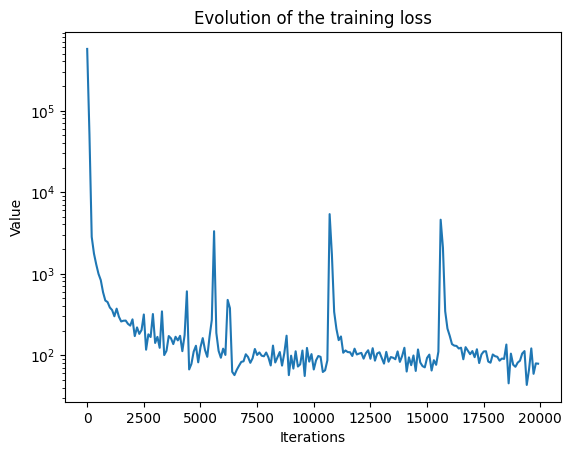

In [25]:
  plt.figure()
  plt.plot(graph[0], graph[1])
  plt.xlabel('Iterations')
  plt.ylabel('Value')
  plt.yscale("log")
  plt.title('Evolution of the training loss')
  plt.savefig(str(D)+ '-dimensional Black-Scholes-Barenblatt' + 'train-loss')

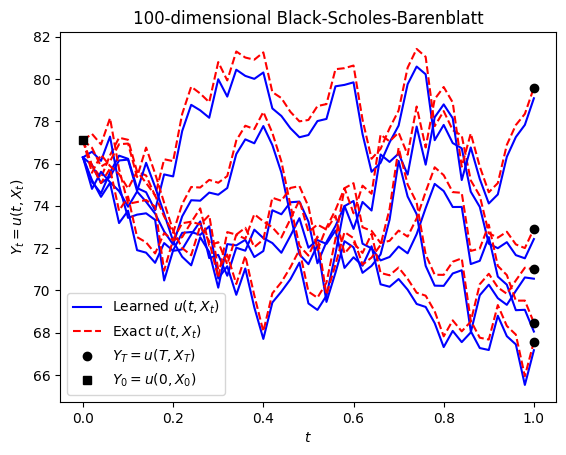

In [26]:
plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, 'b', label='Learned $u(t,X_t)$')
plt.plot(t_test[0:1, :, 0].T, Y_test[0:1, :, 0].T, 'r--', label='Exact $u(t,X_t)$')
plt.plot(t_test[0:1, -1, 0], Y_test[0:1, -1, 0], 'ko', label='$Y_T = u(T,X_T)$')

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T, 'b')
plt.plot(t_test[1:samples, :, 0].T, Y_test[1:samples, :, 0].T, 'r--')
plt.plot(t_test[1:samples, -1, 0], Y_test[1:samples, -1, 0], 'ko')

plt.plot([0], Y_test[0, 0, 0], 'ks', label='$Y_0 = u(0,X_0)$')

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt')
plt.legend()
plt.savefig(str(D) +'-dimensional Black-Scholes-Barenblatt' + 'traces')

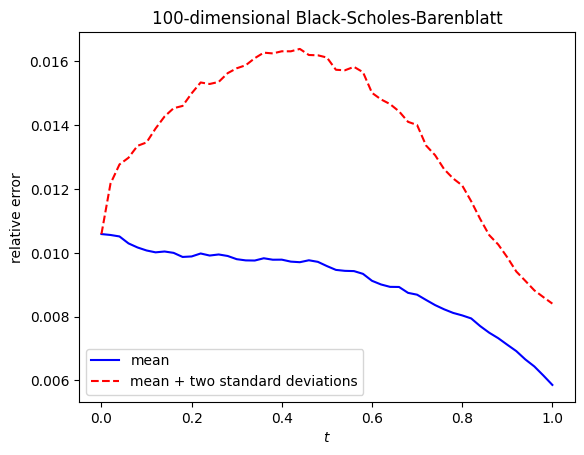

In [27]:
import numpy as np
errors = np.sqrt((Y_test - Y_pred) ** 2 / Y_test ** 2)
mean_errors = np.mean(errors, 0)
std_errors = np.std(errors, 0)

plt.figure()
plt.plot(t_test[0, :, 0], mean_errors, 'b', label='mean')
plt.plot(t_test[0, :, 0], mean_errors + 2 * std_errors, 'r--', label='mean + two standard deviations')
plt.xlabel('$t$')
plt.ylabel('relative error')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt')
plt.legend()
plt.savefig(str(D) + '-dimensional Black-Scholes-Barenblatt' + 'error')